<a href="https://colab.research.google.com/github/BirenderPanwar/EVA4_Phase1/blob/master/session10/EVA4S10_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objectives:
1. Implement LR Finder (for SGD, not for ADAM)
2. Implement ReduceLROnPlatea:
3. Apply CutOut Data Augmentaion using albumentations library
4. Find best LR to train your model
5. Use SDG with Momentum
6. Train for 50 Epochs and Show Training and Test Accuracy curves
7. Applying GradCAM on misclassified images



In [0]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Check for current directory and necessary files availability

In [0]:
# check current directory
!pwd

/content


In [0]:
# change to working directory
cd '/content/gdrive/My Drive/TSAI/EVA_Phase1/session10/s10_submission/'

/content/gdrive/My Drive/TSAI/EVA_Phase1/session10/s10_submission


In [0]:
# verify if all necessary files are avaiabale in current directory for loading
!ls

print("\nfiles under /models: ")
!ls ./models/

print("\nfiles under /utils: ")
!ls ./utils/

print("\nfiles under /gradcam: ")
!ls ./gradcam/

data		    EVA4S10_main_v1.ipynb  images  readme.md	 utils
EVA4S10_main.ipynb  gradcam		   models  saved_models

files under /models: 
cifar10_net_cnn.py  resnet.py

files under /utils: 
albumentations_utils.py  data_utils.py	model_history.py  plot_utils.py
common_utils.py		 lr_finder.py	model_utils.py	  regularization.py

files under /gradcam: 
gradcam_abs.py	gradcam.py  gradcam_utils.py


# Load standard and custom python packages

In [0]:
# Load standard packages

from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CyclicLR, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder

In [0]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations # --no-cache-dir

0.4.5


In [0]:
# load custom python packages
import utils.common_utils as cutils          # common utililies fxn
import utils.model_utils as mutils           # utilities for basic conv block, depthwise seperable blocks, train, test, build fucntions
import utils.model_history as model_history  # utilitie for storing and visualizing model results
from utils.plot_utils import PlotUtils       # utilities for ploting images, model history, misclassified images etc
import models.cifar10_net_cnn as cifar10_net_cnn  # CIFAR10 network design using custom CNN network
import models.resnet as resnet                    # resnet model

import utils.albumentations_utils as album_utils # utilities fxn based on albumentations
import gradcam.gradcam_abs as gradcamAbs         # abstraction for GradCam module

In [0]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload

# Check GPU avaiability
use cuda and get device with GPU

In [0]:
# check GPU availability and use cuda to get GPU device
cuda, device = cutils.get_device()

CUDA Available? True
Device:  cuda:0


# Basis configurations for CIFAR10

In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

config_params = dict(
    seed=1,
    batch_size=128,
    num_workers=4,
    epochs=50
)

# For reproducibility
torch.manual_seed(config_params["seed"])

if cuda:
    torch.cuda.manual_seed(config_params["seed"])

# Albumentations: Data Preprocessing and Loading of  CIFAR10 dataset
1. first calculate the mean and std for the entire dataset. this will be used for dataset normalization during data transform
2. define data transforms: image augmentation, toSensor, normalization etc
3. load the dataset using data loader

In [0]:
means, stds = album_utils.calculate_dataset_mean_std()
print("means: {}".format(means))
print("stds: {}".format(stds))

Files already downloaded and verified
Files already downloaded and verified

Total dataset(train+test) shape:  (60000, 32, 32, 3)
means: [0.49186864, 0.48265335, 0.44717798]
stds: [0.24697131, 0.24338901, 0.26159254]


In [0]:
# fill values for cutout portion
fill_value = [255. * mean for mean in means]

# to apply specific augmentation, set apply=True
# augmentaion is ignore is either apply=False or speific a attribute is missing
albumentations_args = dict(
            GeneralParams=dict(input_size=32),            
            RandomCrop=dict(apply=False, size=8, p=0.20),
            HorizontalFlip=dict(apply=True, p=0.7),
            ElasticTransform=dict(apply=False, sigma=50, alpha=1, alpha_affine=10, p=0.10),
            CoarseDropout=dict(apply=True, max_holes=1, max_height=16, max_width=16, min_height=4, min_width=4, fill_value=fill_value, p=0.70),
            Normalize=dict(apply=True, means=means, stds=stds))

albumentations_args

{'CoarseDropout': {'apply': True,
  'fill_value': [125.42650446295738, 123.07660415768623, 114.03038397431374],
  'max_height': 16,
  'max_holes': 1,
  'max_width': 16,
  'min_height': 4,
  'min_width': 4,
  'p': 0.7},
 'ElasticTransform': {'alpha': 1,
  'alpha_affine': 10,
  'apply': False,
  'p': 0.1,
  'sigma': 50},
 'GeneralParams': {'input_size': 32},
 'HorizontalFlip': {'apply': True, 'p': 0.7},
 'Normalize': {'apply': True,
  'means': [0.49186864, 0.48265335, 0.44717798],
  'stds': [0.24697131, 0.24338901, 0.26159254]},
 'RandomCrop': {'apply': False, 'p': 0.2, 'size': 8}}

In [0]:
# data transform
train_transforms, test_transforms = album_utils.get_data_transform(albumentations_args)

CoarseDropout/Cutout is enabled
HorizontalFlip is enabled


In [0]:
# load data
train_loader, test_loader = album_utils.get_dataloader(train_transforms, test_transforms, 
                                                       batch_size=config_params["batch_size"], num_workers=config_params["num_workers"])

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


# Visualize few training dataset and aurmented images

In [0]:
# create PlotUtils class instance
putils = PlotUtils(device, classes, means, stds)

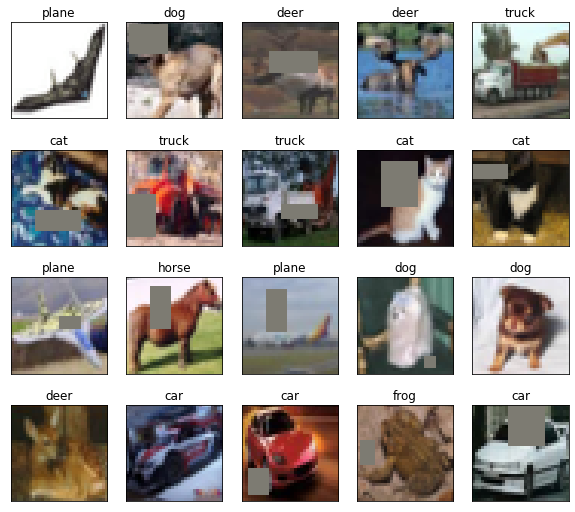

In [0]:
# visualize how image aumentation is applied on few training dataset images: 
putils.plot_dataset_images(train_loader, save_filename="albumentations_images")

# Create Resnet18 based CIFAR10 Network

In [0]:
# Create CIFAR10 network using custome CNN network
#model = cifar10_net_cnn.Cifar10Net(drop_val=0.10)
#mutils.model_summary(model, device, input_size=(3, 32, 32))

In [0]:
# Create CIFAR10 network
model = resnet.ResNet18()
mutils.model_summary(model, device, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

# LRFinder

The model is trained for num_iter iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to end_lr. The increase can be linear (step_mode="linear") or exponential (step_mode="exp"); linear provides good results for small ranges while exponential is recommended for larger ranges

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, weight_decay=1e-3)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=200, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


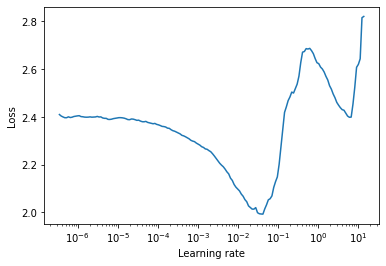

In [0]:
# Note that the loss in the loss vs. learning rate plot is the training loss.
lr_finder.plot()

In [0]:
# To restore the model and optimizer to their initial state
lr_finder.reset()

'''
Here model is evaluated on that validation dataset after each iteration.
The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. 
The disadvantage is that it takes significantly longer to run
'''
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=200, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


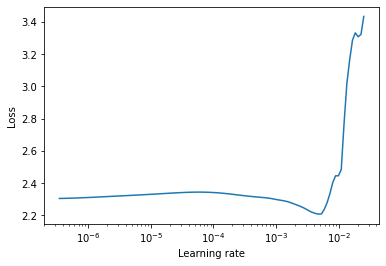

In [0]:
# Note that the loss in the loss vs. learning rate plot is the validation loss.
lr_finder.plot()

# Build and train model

In [0]:
model_name = "CIFAR10 Resnet18"
model =  model.to(device)
EPOCHS = config_params["epochs"]

start_lr = 1e-4 # minimum LR as per LRFinder result
end_lr = 5e-2   # maximu LR as per LRFinder result
step_size = 6   # stepsize for Lr cycle policy

#criterion = F.nll_loss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)  # using L2 Regulaization

# CyclicLR-Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=start_lr, max_lr=end_lr, step_size_up=step_size, mode='triangular2')
#lr_scheduler = MultiStepLR(optimizer, milestones=[8,16,24], gamma=0.3)
#lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

# reduce LR when modle get stuck in plateu region
reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)

model_history = mutils.build_model(model, 
                            device, 
                            trainloader=train_loader, 
                            testloader=test_loader, 
                            epochs=EPOCHS,
                            criterion=criterion, 
                            optimizer=optimizer,
                            lr_scheduler=lr_scheduler,
                            reduceLr_scheduler=reduceLr_scheduler,
                            L1_loss_enable=True)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH-1: learning rate is: 0.0001


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.512032, Accuracy: 4474/10000 (44.74%)

EPOCH-2: learning rate is: 0.008416666666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.273598, Accuracy: 5645/10000 (56.45%)

EPOCH-3: learning rate is: 0.01673333333333334


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.922623, Accuracy: 6936/10000 (69.36%)

EPOCH-4: learning rate is: 0.02505


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.802282, Accuracy: 7328/10000 (73.28%)

EPOCH-5: learning rate is: 0.03336666666666666


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.663064, Accuracy: 7705/10000 (77.05%)

EPOCH-6: learning rate is: 0.04168333333333334


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.702172, Accuracy: 7671/10000 (76.71%)

EPOCH-7: learning rate is: 0.05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.574358, Accuracy: 8066/10000 (80.66%)

EPOCH-8: learning rate is: 0.04168333333333332


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.713006, Accuracy: 7715/10000 (77.15%)

EPOCH-9: learning rate is: 0.03336666666666668


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.525144, Accuracy: 8278/10000 (82.78%)

EPOCH-10: learning rate is: 0.02505


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.447802, Accuracy: 8533/10000 (85.33%)

EPOCH-11: learning rate is: 0.01673333333333332


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.498506, Accuracy: 8412/10000 (84.12%)

EPOCH-12: learning rate is: 0.008416666666666682


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.346898, Accuracy: 8825/10000 (88.25%)

EPOCH-13: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.312045, Accuracy: 8964/10000 (89.64%)

EPOCH-14: learning rate is: 0.004258333333333319


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.317316, Accuracy: 8953/10000 (89.53%)

EPOCH-15: learning rate is: 0.008416666666666682


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.376040, Accuracy: 8775/10000 (87.75%)

EPOCH-16: learning rate is: 0.012575


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.550431, Accuracy: 8362/10000 (83.62%)

EPOCH-17: learning rate is: 0.01673333333333332


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.499423, Accuracy: 8423/10000 (84.23%)

EPOCH-18: learning rate is: 0.02089166666666668


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.488870, Accuracy: 8396/10000 (83.96%)

EPOCH-19: learning rate is: 0.0025050000000000003


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.305527, Accuracy: 8987/10000 (89.87%)

EPOCH-20: learning rate is: 0.02089166666666668


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.489664, Accuracy: 8419/10000 (84.19%)

EPOCH-21: learning rate is: 0.01673333333333332


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.463037, Accuracy: 8529/10000 (85.29%)

EPOCH-22: learning rate is: 0.012575


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.418828, Accuracy: 8648/10000 (86.48%)

EPOCH-23: learning rate is: 0.008416666666666682


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.374202, Accuracy: 8806/10000 (88.06%)

EPOCH-24: learning rate is: 0.004258333333333319


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.302142, Accuracy: 9044/10000 (90.44%)

EPOCH-25: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.289281, Accuracy: 9067/10000 (90.67%)

EPOCH-26: learning rate is: 0.0021791666666666704


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.288821, Accuracy: 9080/10000 (90.80%)

EPOCH-27: learning rate is: 0.00425833333333333


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.312572, Accuracy: 9019/10000 (90.19%)

EPOCH-28: learning rate is: 0.0063375


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.349253, Accuracy: 8914/10000 (89.14%)

EPOCH-29: learning rate is: 0.00841666666666667


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.344985, Accuracy: 8897/10000 (88.97%)

EPOCH-30: learning rate is: 0.01049583333333333


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.505223, Accuracy: 8514/10000 (85.14%)

EPOCH-31: learning rate is: 0.012575


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.548287, Accuracy: 8382/10000 (83.82%)

EPOCH-32: learning rate is: 0.001049583333333333


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.300404, Accuracy: 9050/10000 (90.50%)

EPOCH-33: learning rate is: 0.00841666666666667


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.468522, Accuracy: 8597/10000 (85.97%)

EPOCH-34: learning rate is: 0.0063375


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.359799, Accuracy: 8904/10000 (89.04%)

EPOCH-35: learning rate is: 0.00425833333333333


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.319271, Accuracy: 9016/10000 (90.16%)

EPOCH-36: learning rate is: 0.0021791666666666704


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.297491, Accuracy: 9093/10000 (90.93%)

EPOCH-37: learning rate is: 1e-05


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.290206, Accuracy: 9112/10000 (91.12%)

EPOCH-38: learning rate is: 0.0011395833333333407


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.288574, Accuracy: 9111/10000 (91.11%)

EPOCH-39: learning rate is: 0.002179166666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.309630, Accuracy: 9076/10000 (90.76%)

EPOCH-40: learning rate is: 0.00321875


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.311480, Accuracy: 9083/10000 (90.83%)

EPOCH-41: learning rate is: 0.004258333333333341


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.327629, Accuracy: 9027/10000 (90.27%)

EPOCH-42: learning rate is: 0.0005297916666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.286780, Accuracy: 9144/10000 (91.44%)

EPOCH-43: learning rate is: 0.0063375


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.397031, Accuracy: 8820/10000 (88.20%)

EPOCH-44: learning rate is: 0.005297916666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.344021, Accuracy: 8934/10000 (89.34%)

EPOCH-45: learning rate is: 0.004258333333333341


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.332522, Accuracy: 8991/10000 (89.91%)

EPOCH-46: learning rate is: 0.00321875


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.325618, Accuracy: 9055/10000 (90.55%)

EPOCH-47: learning rate is: 0.002179166666666659


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.292033, Accuracy: 9105/10000 (91.05%)

EPOCH-48: learning rate is: 0.00011395833333333407


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.285398, Accuracy: 9134/10000 (91.34%)

EPOCH-49: learning rate is: 0.0001


  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.291720, Accuracy: 9147/10000 (91.47%)

EPOCH-50: learning rate is: 0.0006197916666666649


Loss=0.147815 Batch_id=391 Accuracy=99.43: 100%|██████████| 391/391 [00:58<00:00,  6.64it/s]



Test set: Average loss: 0.281299, Accuracy: 9155/10000 (91.55%)



In [0]:
# Save the model for future use
filepath = "./saved_models/s10_resnet18"
torch.save(model, filepath)

# Analyse the train and test best result and calculate test accuracy for each classes

In [0]:
# model result summary
model_history.result_summary()

Training best result: Accuracy: 99.43 at Epoch 49
Testing  best result: Accuracy: 91.55 at Epoch 50
Acuracy Gap: 7.88


In [0]:
# get class based test accuracy for the network
mutils.class_based_accuracy(model, device, classes, test_loader)

Accuracy of plane : 95 %
Accuracy of   car : 94 %
Accuracy of  bird : 79 %
Accuracy of   cat : 77 %
Accuracy of  deer : 92 %
Accuracy of   dog : 86 %
Accuracy of  frog : 95 %
Accuracy of horse : 97 %
Accuracy of  ship : 94 %
Accuracy of truck : 89 %


# Visualize model history and network convergence

Visulaizing train and test result history

/content/gdrive/My Drive/TSAI/EVA_Phase1/session10/s10_submission/utils/model_history.py:110: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,x_size+1),x_size/10)
/content/gdrive/My Drive/TSAI/EVA_Phase1/session10/s10_submission/utils/model_history.py:121: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,x_size+1),x_size/10)


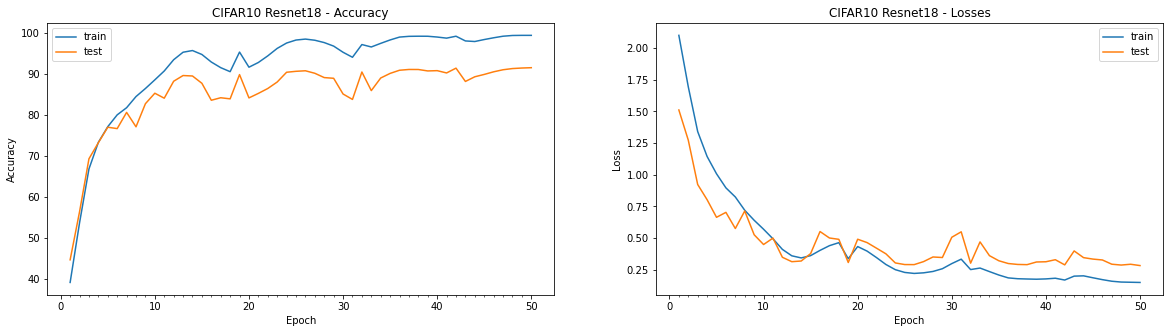

In [0]:
# Accurracy and loss history plot
model_history.plot_history(title=model_name, save_filename="model_history")

Learning rate plot

/content/gdrive/My Drive/TSAI/EVA_Phase1/session10/s10_submission/utils/model_history.py:68: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs.set_xticks(np.arange(1,x_size+1),x_size/10)


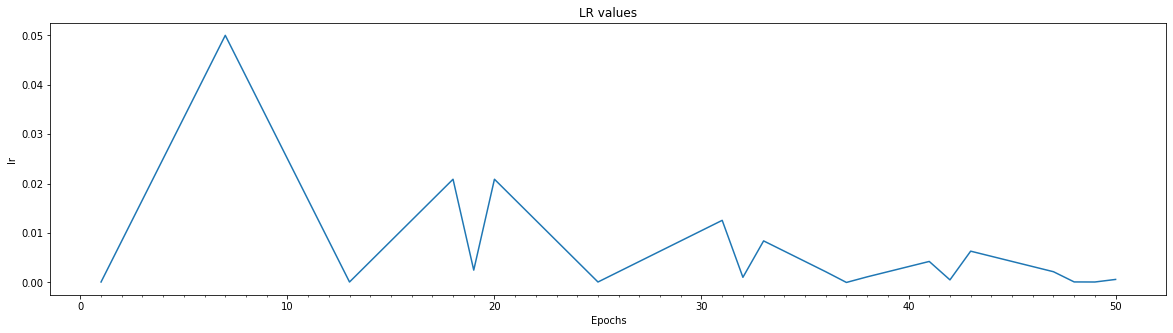

In [0]:
# Note: seriesname="val_acc", "val_loss", "train_acc", "train_loss", "lr"
model_history.plot_data_against_epoch("LR values", seriesname="lr", save_filename="lr_trend")

Visualize few misclassified images and get an understanding on for what set of unseen data model is not performing good 


Ploting misclassified images: CIFAR10 Resnet18



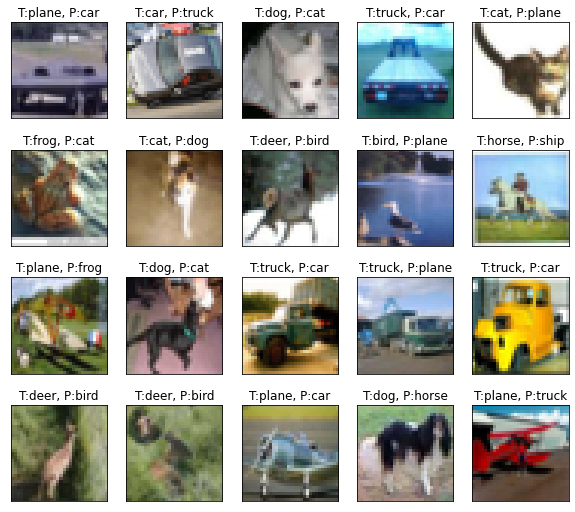

In [0]:
print("\nPloting misclassified images: {}\n".format(model_name))
putils.plot_misclassified_images(model, testloader=test_loader, save_filename="model_misclassified")

# GradCAM

In [0]:
# reload the saved model
#filepath = "./saved_models/s10_resnet18_v1"
#model = torch.load(filepath)
#model_name = "CIFAR10 Resnet18"

In [0]:
# create instance of GradCam module
config = dict(model_type='resnet', arch=model, layer_name='layer4')
gcam = gradcamAbs.GradCamAbs(device, config, means, stds)

In [0]:
# apply GradCAM on few of the test images - misclassified images
gradcam_images, pred_results = gcam.applyOnMisclassifiedImages(dataloader=test_loader, num_of_images=25)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


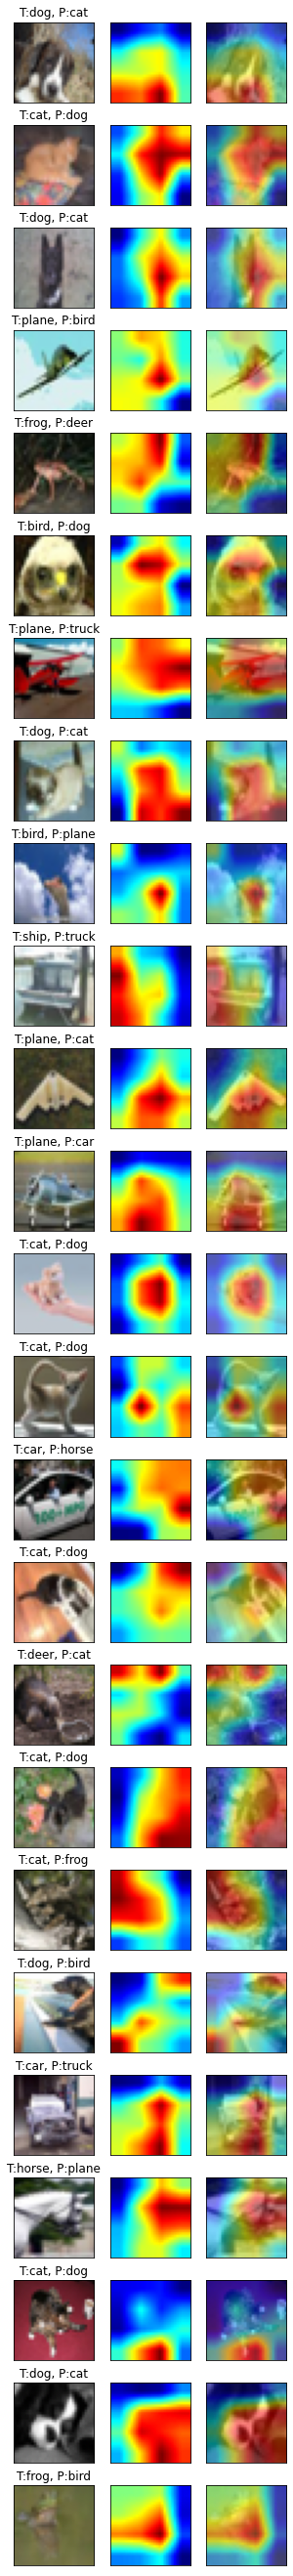

In [0]:
# plot the GradCAM result: original img, heatmap and super imposed image
gcam.plot_results(gradcam_images, pred_results, classes, save_filename="gradcam_result_details")

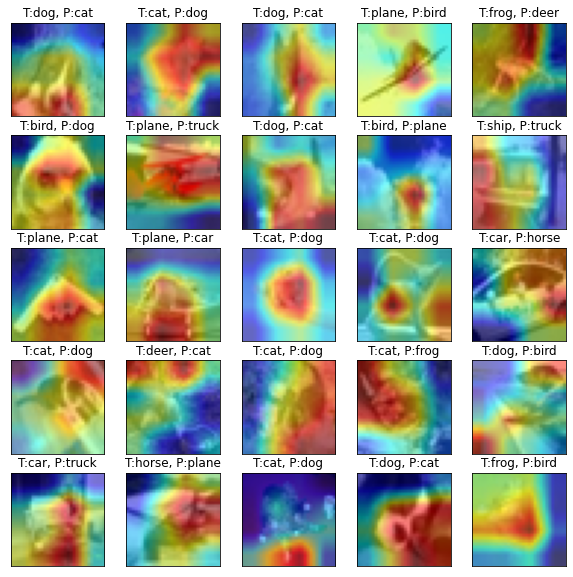

In [0]:
# plot the GradCAM result: only super imposed image
gcam.plot_cam_images(gradcam_images, pred_results, classes, save_filename="gradcam_superimposed_result")